**Submitted By: Danielle Yaffe, Guy Zalsman and Raz Ohayon**

# Assignment 3: Image Classification

**Assignment Responsible**: Natalie Lang.

In this assignment, we will build a convolutional neural network that can predict 
whether two shoes are from the **same pair** or from two **different pairs**.
This kind of application can have real-world applications: for example to help
people who are visually impaired to have more independence.

We will explore two convolutional architectures. While we will give you starter
code to help make data processing a bit easier, in this assignment you have a chance to build your neural network all by yourself. 

You may modify the starter code as you see fit, including changing the signatures of
functions and adding/removing helper functions. However, please make sure that we can understand what you are doing and why.
 

In [ ]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random

## Question 1. Data (20%)

Download the data from https://www.dropbox.com/s/6gdcpmfddojrl8o/data.rar?dl=0.

Unzip the file. There are three
main folders: `train`, `test_w` and `test_m`. Data in `train` will be used for
training and validation, and the data in the other folders will be used for testing.
This is so that the entire class will have the same test sets. The dataset is comprised of triplets of pairs, where each such triplet of image pairs was taken in a similar setting (by the same person).

We've separated `test_w` and `test_m` so that we can track our model performance 
for women's shoes and men's shoes separately. Each of the test sets contain images of either exclusively men's shoes or women's
shoes.

Upload this data to Google Colab.
Then, mount Google Drive from your Google Colab notebook:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


After you have done so, read this entire section 
before proceeding. There are right and wrong ways of
processing this data. If you don't make the correct choices, you may find
yourself needing to start over.
Many machine learning projects fail because of the lack of care taken during
the data processing stage.

### Part (a) -- 8%

Load the training and test data, and separate your training data into training and validation.
Create the numpy arrays `train_data`, `valid_data`, `test_w` and `test_m`, all of which should
be of shape `[*, 3, 2, 224, 224, 3]`. The dimensions of these numpy arrays are as follows:

- `*` - the number of triplets allocated to train, valid, or test
- `3` - the 3 pairs of shoe images in that triplet
- `2` - the left/right shoes
- `224` - the height of each image
- `224` - the width of each image
- `3` - the colour channels

So, the item `train_data[4,0,0,:,:,:]` should give us the left shoe of the first image of the fifth person.The item `train_data[4,0,1,:,:,:]`  should be the right shoe in the same pair. 
The item `train_data[4,1,1,:,:,:]`  should be the right shoe in a different pair of that same person.

When you first load the images using (for example) `plt.imread`, you may see a numpy array of shape
`[224, 224, 4]` instead of `[224, 224, 3]`. That last channel is what's called the alpha channel for transparent
pixels, and should be removed. 
The pixel intensities are stored as an integer between 0 and 255.
Make sure you normlize your images, namely, divide the intensities by 255 so that you have floating-point values between 0 and 1. Then, subtract 0.5
so that the elements of `train_data`, `valid_data` and `test_data` are between -0.5 and 0.5.
**Note that this step actually makes a huge difference in training!**

This function might take a while to run; it can takes several minutes to just
load the files from Google Drive.  If you want to avoid
running this code multiple times, you can save 
your numpy arrays and load it later:
https://docs.scipy.org/doc/numpy/reference/generated/numpy.save.html

In [ ]:
# Your code goes here. Make sure it does not get cut off
# You can use the code below to help you get started. You're welcome to modify
# the code or remove it entirely: it's just here so that you don't get stuck
# reading files

import glob
path = "/content/gdrive/My Drive/Intro_to_Deep_Learning/data_asg3/train/*.jpg" # TODO - UPDATE ME!
images = {}
for file in glob.glob(path):
    filename = file.split("/")[-1]   # get the name of the .jpg file
    img = plt.imread(file)           # read the image as a numpy array
    images[filename] = img[:, :, :3] # remove the alpha channel

sorted_img_array = dict(sorted(images.items()))
#num_of_u = 112
#init
sz = [112, 3, 2, 224, 224, 3]
train_data = np.zeros(sz)
user = 0
tuple_num = 0
d = 0

for img in sorted_img_array:
  if tuple_num == 2 and d==1:
    user +=1
  tuple_num = int(img[5])-1
  direction = img[7]
  d = 0 #left shoe image
  if direction == 'r':
    d = 1
  val = images[img]
  val = (val/255) -0.5
  train_data[user,tuple_num,d,:,:,0] = val[:,:,0]
  train_data[user,tuple_num,d,:,:,1] = val[:,:,1]
  train_data[user,tuple_num,d,:,:,2] = val[:,:,2]


In [ ]:
path = "/content/gdrive/My Drive/Intro_to_Deep_Learning/data_asg3/train/test_m/*.jpg"
images_test_m = {}

for file in glob.glob(path):
    filename = file.split("/")[-1]   # get the name of the .jpg file
    img = plt.imread(file)           # read the image as a numpy array
    images_test_m[filename] = img[:, :, :3] # remove the alpha channel

sorted_img_array = dict(sorted(images_test_m.items()))
#init
sz = [int(len(sorted_img_array)/6), 3, 2, 224, 224, 3]
test_m = np.zeros(sz)
user = 0
tuple_num = 0
d = 0

for img in sorted_img_array:
  if tuple_num == 2 and d==1:
    user +=1
  tuple_num = int(img[5])-1
  direction = img[7]
  d = 0 #left shoe image
  if direction == 'r':
    d = 1
  val = sorted_img_array[img]
  val = val/255 -0.5
  test_m[user,tuple_num,d,:,:,0] = val[:,:,0]
  test_m[user,tuple_num,d,:,:,1] = val[:,:,1]
  test_m[user,tuple_num,d,:,:,2] = val[:,:,2]

In [ ]:
path = "/content/gdrive/My Drive/Intro_to_Deep_Learning/data_asg3/train/test_w/*.jpg" # TODO - UPDATE ME!
images_test_w = {}

for file in glob.glob(path):
    filename = file.split("/")[-1]   # get the name of the .jpg file
    img = plt.imread(file)           # read the image as a numpy array
    images_test_w[filename] = img[:, :, :3] # remove the alpha channel

sorted_img_array = dict(sorted(images_test_w.items()))
#init
sz = [int(len(sorted_img_array)/6), 3, 2, 224, 224, 3]
test_w = np.zeros(sz)
user = 0
tuple_num = 0
d = 0

for img in sorted_img_array:
  if tuple_num == 2 and d==1:
    user +=1  
  tuple_num = int(img[5])-1
  direction = img[7]
  d = 0 #left shoe image
  if direction == 'r':
    d = 1
  val = sorted_img_array[img]
  val = val/255 -0.5
  test_w[user,tuple_num,d,:,:,0] = val[:,:,0]
  test_w[user,tuple_num,d,:,:,1] = val[:,:,1]
  test_w[user,tuple_num,d,:,:,2] = val[:,:,2]



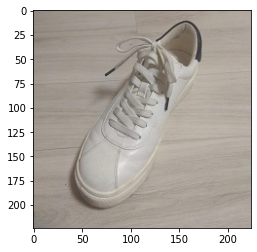

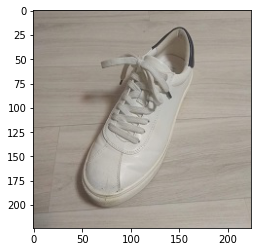

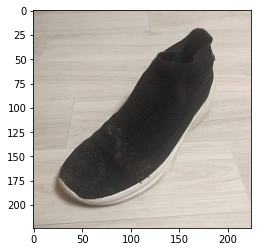

In [ ]:
# Run this code, include the image in your PDF submission
plt.figure()
plt.imshow(train_data[4,0,0,:,:,:]+0.5) # left shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,0,1,:,:,:]+0.5) # right shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,1,1,:,:,:]+0.5) # right shoe of second pair submitted by 5th student

### Part (b) -- 4%

Since we want to train a model that determines whether two shoes come from the **same**
pair or **different** pairs, we need to create some labelled training data.
Our model will take in an image, either consisting of two shoes from the **same pair**
or from **different pairs**. So, we'll need to generate some *positive examples* with
images containing two shoes that *are* from the same pair, and some *negative examples* where 
images containing two shoes that *are not* from the same pair.
We'll generate the *positive examples* in this part, and the *negative examples* in the next part.

Write a function `generate_same_pair()` that takes one of the data sets that you produced
in part (a), and generates a numpy array where each pair of shoes in the data set is
concatenated together. In particular, we'll be concatenating together images of left
and right shoes along the **height** axis. Your function `generate_same_pair` should
return a  numpy array of shape `[*, 448, 224, 3]`.

While at this stage we are working with numpy arrays, later on, we will need to convert this numpy array into a PyTorch tensor with shape
`[*, 3, 448, 224]`. For now, we'll keep the RGB channel as the last dimension since
that's what `plt.imshow` requires.

(112, 3, 2, 224, 224, 3)
(336, 448, 224, 3)


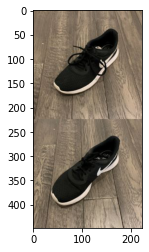

In [ ]:
# Your code goes here
def generate_same_pair(data_set):
  sz = [int(len(data_set)*3), 448, 224, 3]
  same_pairs = np.zeros(sz)
  new_user = 0 

  for user in range(0,len(data_set)):
    same_pairs[new_user,:,:,:] = np.concatenate((data_set[user,0,0,:,:,:],data_set[user,0,1,:,:,:]))
    same_pairs[new_user+1,:,:,:] = np.concatenate((data_set[user,1,0,:,:,:],data_set[user,1,1,:,:,:]))
    same_pairs[new_user+2,:,:,:] = np.concatenate((data_set[user,2,0,:,:,:],data_set[user,2,1,:,:,:]))
    new_user = new_user + 3

  return same_pairs

# Run this code, include the result with your PDF submission
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_same_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_same_pair(train_data)[0]+0.5) # should show 2 shoes from the same pair

### Part (c) -- 4%

Write a function `generate_different_pair()` that takes one of the data sets that
you produced in part (a), and generates a numpy array in the same shape as part (b).
However, each image will contain 2 shoes from a **different** pair, but submitted
by the **same student**. Do this by jumbling the 3 pairs of shoes submitted by 
each student.

Theoretically, for each person (triplet of pairs), there are 6 different combinations
of "wrong pairs" that we could produce. To keep our data set *balanced*, we will
only produce **three** combinations of wrong pairs per unique person.
In other words,`generate_same_pairs` and `generate_different_pairs` should
return the same number of training examples.

(112, 3, 2, 224, 224, 3)
(336, 448, 224, 3)


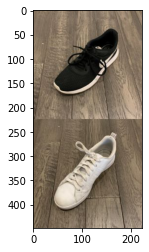

In [ ]:
# Your code goes here

def generate_different_pair(data_set):
  sz = [int(len(data_set)*3), 448, 224, 3]
  dif_pairs = np.zeros(sz)
  new_user = 0 
  opt = [np.array([1,2,0]),np.array([2,0,1])]
  for user in range(0,len(data_set)):
    place = random.choice(opt)
    dif_pairs[new_user,:,:,:] = np.concatenate((data_set[user,0,0,:,:,:],data_set[user,place[0],1,:,:,:]))
    dif_pairs[new_user+1,:,:,:] = np.concatenate((data_set[user,1,0,:,:,:],data_set[user,place[1],1,:,:,:]))
    dif_pairs[new_user+2,:,:,:] = np.concatenate((data_set[user,2,0,:,:,:],data_set[user,place[2],1,:,:,:]))
    new_user = new_user + 3

  return dif_pairs

# Run this code, include the result with your PDF submission
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_different_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_different_pair(train_data)[0]+0.5) # should show 2 shoes from different pairs


In [ ]:
val_data = train_data[101:]
train_data = train_data[:101]

print(train_data.shape)
print(val_data.shape)

(101, 3, 2, 224, 224, 3)
(11, 3, 2, 224, 224, 3)


### Part (d) -- 2%

Why do we insist that the different pairs of shoes still come from the same
person?  (Hint: what else do images from the same person have in common?)

**Write your explanation here:**

Images from the same person will have similar properties like the angle that the image was captured, background features, size, style, etc. We want the model to learn to find similar pairs based on the shoe itself and not other features of the image meaning we don't want two shoes captured in the same light or two shoes with the same size to be matched only for that reasons. Insisting that the differents pairs are from the same person forces the model to concentrate and pull the important information and differences between shoes like shape, shoe color, laces etc to understand which shoes are truely pairs.

CNN is learning to recognize the common characteristics and patterns presented in these images in order to classify them appropriately.

### Part (e) -- 2%

Why is it important that our data set be *balanced*? In other words suppose we created
a data set where 99% of the images are of shoes that are *not* from the same pair, and 
1% of the images are shoes that *are* from the same pair. Why could this be a problem?

**Write your explanation here:**

We discussed in lecture one that if our data
samples are generated in an i.i.d. manner from the true distribution P, then by the law of large numbers, the empirical risk is expected to converge to the true risk. An unbalances data set will not represent i.i.d samples from distribution P but a different distribution for which the model becomes biased in favor of the majority class (different pairs).

## Question 2. Convolutional Neural Networks (25%)

Before starting this question, we recommend reviewing the lecture and its associated example notebook on CNNs.

In this section, we will build two CNN models in PyTorch.

### Part (a) -- 9%

Implement a CNN model in PyTorch called `CNN` that will take images of size
$3 \times 448 \times 224$, and classify whether the images contain shoes from
the same pair or from different pairs.

The model should contain the following layers:

- A convolution layer that takes in 3 channels, and outputs $n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A second convolution layer that takes in $n$ channels, and outputs $2\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A third convolution layer that takes in $2\cdot n$ channels, and outputs $4\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fourth convolution layer that takes in $4\cdot n$ channels, and outputs $8\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fully-connected layer with 100 hidden units
- A fully-connected layer with 2 hidden units

Make the variable $n$ a parameter of your CNN. You can use either $3 \times 3$ or $5 \times 5$
convolutions kernels. Set your padding to be `(kernel_size - 1) / 2` so that your feature maps
have an even height/width.

Note that we are omitting in our description certain steps that practitioners will typically not mention,
like ReLU activations and reshaping operations. Use the example presented in class to figure out where they are.

In [ ]:
class CNN(nn.Module):
    def __init__(self, n_feature=4,kernel_size=5):
        super(CNN, self).__init__()
        # TODO: complete this method
        self.n = n_feature
        self.kernel_sz = kernel_size
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.n, kernel_size=self.kernel_sz, padding = (self.kernel_sz-1)//2)
        self.conv2 = nn.Conv2d(self.n, 2*self.n, self.kernel_sz, padding = (self.kernel_sz-1)//2)
        self.conv3 = nn.Conv2d(2*self.n, 4*self.n, self.kernel_sz, padding = (self.kernel_sz-1)//2)
        self.conv4 = nn.Conv2d(4*self.n, 8*self.n, self.kernel_sz, padding = (self.kernel_sz-1)//2)
        self.fc1 = nn.Linear(8*self.n*28*14, 100)
        self.fc2 = nn.Linear(100, 2)

    # TODO: complete this class
    def forward(self, x, verbose=False):
        #x should be of size: [batch_size, 3, 224, 448]
        x = x.transpose(2,3) #x should be of size: [batch_size, 3, 448, 224]
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        x = x.reshape(-1, 8*self.n*28*14)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        return x

### Part (b) -- 8%

Implement a CNN model in PyTorch called `CNNChannel` that contains the same layers as
in the Part (a), but with one crucial difference: instead of starting with an image
of shape $3 \times 448 \times 224$, we will first manipulate the image so that the
left and right shoes images are concatenated along the **channel** dimension.

<img src="https://drive.google.com/uc?id=1B59VE43X-6Dw3ag-9Ndn6vPEzbnFem8K" width="400px" />


Complete the manipulation in the `forward()` method (by slicing and using
the function `torch.cat`). The input to the first convolutional layer
should have 6 channels instead of 3 (input shape $6 \times 224 \times 224$).

Use the same hyperparameter choices as you did in part (a), e.g. for the kernel size,
choice of downsampling, and other choices.

In [ ]:
class CNNChannel(nn.Module):
    def __init__(self, n_feature=4, kernel_sz=5):
        super(CNNChannel, self).__init__()
        # TODO: complete this method
        self.n = n_feature
        self.kernel_sz = kernel_sz
        self.padding_size = (kernel_sz-1)//2 

        self.conv1 = nn.Conv2d(in_channels=6, out_channels=n_feature, kernel_size=kernel_sz, padding=(kernel_sz-1)//2)
        self.conv2 = nn.Conv2d(n_feature, 2*n_feature, kernel_size=kernel_sz, padding=(kernel_sz-1)//2)
        self.conv3 = nn.Conv2d(2*n_feature, 4*n_feature, kernel_size=kernel_sz, padding=(kernel_sz-1)//2)
        self.conv4 = nn.Conv2d(4*n_feature, 8*n_feature, kernel_size=kernel_sz, padding=(kernel_sz-1)//2)
        self.fc1 = nn.Linear(8*n_feature*14*14, 100)
        self.fc2 = nn.Linear(100, 2)

    # TODO: complete this class
    def forward(self, x, verbose=False): 
        #x should be of size: [batch_size, 3, 224, 448]
        #turn input data to 6 channels
        x = x.transpose(2,3) #size: [batch_size, 3, 448, 224]
        x = torch.cat((x[:,:,:224,:],x[:,:,224:,:]),1) #x should be of size: [batch_size, 6, 224, 224]

        # Constraints for layer 1
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        # Constraints for layer 2
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        # Constraints for layer 3
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        # Constraints for layer 4
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
      
        # Flatten the output of the convolutional layers
        x = x.reshape(-1, 8*self.n*14*14)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
       
        return x

## Part (c) -- 4%

The two models are quite similar, and should have almost the same number of parameters.
However, one of these models will perform better, showing that architecture choices **do**
matter in machine learning. Explain why one of these models performs better.

**Write your explanation here:**

The CNNchannel model will work better. 

As we start with the original matrix dimension for each channel and more channels, we preserve the spacial information. Our data set is comprised from images where the information lies not only in a single pixel but even more in it's neighbors. So we want and expect our model to learn and understand the relationship between a pixel, it's surrounding and the whole image. On the other hand in the CNN model we change the spatial structure of the images by concatenating along the hieght dimention making it much harder for the model to learn and characterize the images. It now tries to understand the relationship between more feauters and elements making it less distinct.  

Also we know that deeper layers generally correspond to more specific and much more complex features hence if we start with more channels we can extract these specific features with less layers. In pictures there are a lot more of those complex features than simple features, so we want more channels to capture them all.


## Part (d) -- 4%

The function `get_accuracy` is written for you. You may need to modify this
function depending on how you set up your model and training.

Unlike in the previous assignment, her we will separately compute the model accuracy on the
positive and negative samples.  Explain why we may wish to track the false positives and false negatives separately.

**Write your explanation here:**

Usually (or until now) we have trained the model on inputs and the corresponding (true) lables. This model learns on the same shoe pairs and also on different shoe pairs.  We have an interest to observe and track the false positives and false negatives separately because this will help us understand the performance of the model on each type of error, and to identify any potential biases or weaknesses in the model's prediction behavior.

This can be useful for improving the model's performance and for making informed decisions about its use in a particular context.

In [ ]:
def get_accuracy(model, data, batch_size=50):
    """Compute the model accuracy on the data set. This function returns two
    separate values: the model accuracy on the positive samples,
    and the model accuracy on the negative samples.

    Example Usage:

    >>> model = CNN() # create untrained model
    >>> pos_acc, neg_acc= get_accuracy(model, valid_data)
    >>> false_positive = 1 - pos_acc
    >>> false_negative = 1 - neg_acc
    """

    model.eval()
    n = data.shape[0]

    data_pos = generate_same_pair(data)      # should have shape [n * 3, 448, 224, 3]
    data_neg = generate_different_pair(data) # should have shape [n * 3, 448, 224, 3]

    pos_correct = 0
    for i in range(0, len(data_pos), batch_size):
        xs = torch.Tensor(data_pos[i:i+batch_size]).transpose(1, 3) # should have shape [n * 3, 3, 224, 448]
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        pos_correct += (pred == 0).sum()
    
    neg_correct = 0
    for i in range(0, len(data_neg), batch_size):
        xs = torch.Tensor(data_neg[i:i+batch_size]).transpose(1, 3) # should have shape [n * 3, 3, 224, 448]
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        neg_correct += (pred == 1).sum()

    return pos_correct / (n * 3), neg_correct / (n * 3)

## Question 3. Training (40%)

Now, we will write the functions required to train the model. 

Although our task is a binary classification problem, we will still use the architecture
of a multi-class classification problem. That is, we'll use a one-hot vector to represent
our target (like we did in the previous assignment). We'll also use `CrossEntropyLoss` instead of
`BCEWithLogitsLoss` (this is a standard practice in machine learning because
this architecture often performs better).

### Part (a) -- 22%

Write the function `train_model` that takes in (as parameters) the model, training data,
validation data, and other hyperparameters like the batch size, weight decay, etc.
This function should be somewhat similar to the training code that you wrote
in Assignment 2, but with a major difference in the way we treat our training data.

Since our positive (shoes of the same pair) and negative (shoes of different pairs) training sets are separate, it is actually easier for
us to generate separate minibatches of positive and negative training data.
 In
each iteration, we'll take `batch_size / 2` positive samples and `batch_size / 2`
negative samples. We will also generate labels of 1's for the positive samples,
and 0's for the negative samples.

Here is what your training function should include:

- main training loop; choice of loss function; choice of optimizer
- obtaining the positive and negative samples
- shuffling the positive and negative samples at the start of each epoch
- in each iteration, take `batch_size / 2` positive samples and `batch_size / 2` negative samples
  as our input for this batch
- in each iteration, take `np.ones(batch_size / 2)` as the labels for the positive samples, and 
  `np.zeros(batch_size / 2)` as the labels for the negative samples
- conversion from numpy arrays to PyTorch tensors, making sure that the input has dimensions $N \times C \times H \times W$ (known as NCHW tensor), where $N$ is the number of images batch size, $C$ is the number of channels, $H$ is the height of the image, and $W$ is the width of the image. 
- computing the forward and backward passes 
- after every epoch, report the accuracies for the training set and validation set
- track the training curve information and plot the training curve

It is also recommended to checkpoint your model (save a copy) after every epoch, as we did in Assignment 2.

In [ ]:
# Write your code here
def shuffle_data(data):
  new_order = np.random.permutation(len(data))
  return data[new_order]

def train_model(model,
                train_data=train_data,
                validation_data=val_data,
                batch_size=100,
                learning_rate=0.001,
                weight_decay=0,
                max_iters=100,
                checkpoint_path=None):
  
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),
                           lr=learning_rate,
                           weight_decay=weight_decay)
    
    half_batch = batch_size//2

    same_pair_data = generate_same_pair(train_data) # should have shape [n * 3, 448, 224, 3]
    dif_pair_data = generate_different_pair(train_data) # should have shape [n * 3, 448, 224, 3]

    iters, losses = [], []
    iters_sub, train_pos_accs, train_neg_accs, val_pos_accs, val_neg_accs  = [], [] ,[] ,[] ,[]

    n = 0 # the number of iterations
    while True:
        #shuffle pairs
        same_pair_data = shuffle_data(same_pair_data)
        dif_pair_data = shuffle_data(dif_pair_data)

        for i in range(0, same_pair_data.shape[0], half_batch):
            if (i + half_batch) > same_pair_data.shape[0]:
                break
            
            # get the input of a minibatch + convert from numpy arrays to PyTorch tensors
            xt_same = torch.Tensor(same_pair_data[i:i+half_batch]).transpose(1, 3) # should have shape [1/2*batch_size, 3, 224, 448]
            xt_dif = torch.Tensor(dif_pair_data[i:i+half_batch]).transpose(1, 3) # should have shape [1/2*batch_size, 3, 224, 448]
            x_data = torch.cat((xt_same, xt_dif), 0)    #[batch_size, 3, 224, 448]

            #get targets of a minibatch
            st_same = torch.zeros((half_batch,2))
            st_same[:,0] = 1
            st_dif = torch.zeros((half_batch,2))
            st_dif[:,1] = 1
            st_data = torch.cat((st_same, st_dif), 0)  #should have shape ([batch_size,2])

            #shuffle batch to avoid learning the place of same and diff
            shuf=np.random.permutation(batch_size)
            x_data=x_data[shuf]
            st_data=st_data[shuf]

            #train
            zs = model(x_data)                    # compute prediction logit
            loss = criterion(zs, st_data)         # compute the total loss
            loss.backward()                       # compute updates for each parameter
            optimizer.step()                      # make the updates for each parameter
            optimizer.zero_grad()                 # a clean up step for PyTorch
       
            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)  # compute *average* loss
          
            if n % 100 == 0:
              iters_sub.append(n)
              train_cost = float(loss.detach().numpy())

              train_pos_acc, train_neg_acc= get_accuracy(model, train_data, batch_size)     
              train_pos_accs.append(train_pos_acc)
              train_neg_accs.append(train_neg_acc)

              val_pos_acc,val_neg_acc = get_accuracy(model, validation_data, batch_size)
              val_pos_accs.append(val_pos_acc)
              val_neg_accs.append(val_neg_acc)


              print("Iter %d.  ([Val Acc %.0f%%, Val (Same) Acc %.0f%%, Val (Dif) Acc %.0f%%]  [Train Acc %.0f%% ,Train (Same) Acc %.0f%%, Train (Dif) Acc %.0f%%, Loss %f]" % (
                  n, 100*(val_pos_acc+val_neg_acc)/2,100*val_pos_acc, 100*val_neg_acc,(train_pos_acc+train_neg_acc) * 100/2 , train_pos_acc * 100, train_neg_acc * 100, train_cost))

              if (checkpoint_path is not None) and n > 0:
                  torch.save(model.state_dict(), checkpoint_path.format(n))

            # increment the iteration number
            n += 1

            if n > max_iters:
                return iters, losses, iters_sub, train_pos_accs, train_neg_accs, val_pos_accs, val_neg_accs
        

def plot_learning_curve(iters, losses, iters_sub, train_pos_accs, train_neg_accs, val_pos_accs, val_neg_accs):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve (same pair): Accuracy per Iteration")
    plt.plot(iters_sub, train_pos_accs, label="Train")
    plt.plot(iters_sub, val_pos_accs, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    plt.title("Learning Curve (different pair): Accuracy per Iteration")
    plt.plot(iters_sub, train_neg_accs, label="Train")
    plt.plot(iters_sub, val_neg_accs, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

### Part (b) -- 6%

Sanity check your code from Q3(a) and from Q2(a) and Q2(b) by showing that your models
can memorize a very small subset of the training set (e.g. 5 images).
You should be able to achieve 90%+ accuracy (don't forget to calculate the accuracy)
relatively quickly (within ~30 or so iterations).


(Start with the second network, it is easier to converge)

Try to find the general parameters combination that work for each network, it can help you a little bit later.

In [ ]:
# Write your code here. Remember to include your results so that we can
# see that your model attains a high training accuracy. 

n_features = 4 # number of feature maps
kernel_size = 5

pytorch_cnn_channel = CNNChannel(n_features,kernel_size)
iters, losses, iters_sub, train_pos_accs, train_neg_accs, val_pos_accs, val_neg_accs = train_model(pytorch_cnn_channel,
                                                                                                   train_data[:1],
                                                                                                    val_data[:1],
                                                                                                    batch_size=2,
                                                                                                    learning_rate=0.0005,
                                                                                                    weight_decay=0,
                                                                                                    max_iters=50,
                                                                                                    checkpoint_path=None)


#plot_learning_curve(iters, losses, iters_sub, train_pos_accs, train_neg_accs, val_pos_accs, val_neg_accs)

Iter 0.  ([Val Acc 50%, Val (Same) Acc 100%, Val (Dif) Acc 0%]  [Train Acc 50% ,Train (Same) Acc 100%, Train (Dif) Acc 0%, Loss 0.693052]
Iter 10.  ([Val Acc 33%, Val (Same) Acc 33%, Val (Dif) Acc 33%]  [Train Acc 83% ,Train (Same) Acc 100%, Train (Dif) Acc 67%, Loss 0.692743]
Iter 20.  ([Val Acc 50%, Val (Same) Acc 0%, Val (Dif) Acc 100%]  [Train Acc 67% ,Train (Same) Acc 33%, Train (Dif) Acc 100%, Loss 0.690748]
Iter 30.  ([Val Acc 50%, Val (Same) Acc 33%, Val (Dif) Acc 67%]  [Train Acc 100% ,Train (Same) Acc 100%, Train (Dif) Acc 100%, Loss 0.660672]
Iter 40.  ([Val Acc 83%, Val (Same) Acc 67%, Val (Dif) Acc 100%]  [Train Acc 100% ,Train (Same) Acc 100%, Train (Dif) Acc 100%, Loss 0.552676]
Iter 50.  ([Val Acc 83%, Val (Same) Acc 67%, Val (Dif) Acc 100%]  [Train Acc 100% ,Train (Same) Acc 100%, Train (Dif) Acc 100%, Loss 0.233634]


In [ ]:
n_features = 8 # number of feature maps
pytorch_cnn = CNN(n_features)
iters, losses, iters_sub, train_pos_accs, train_neg_accs, val_pos_accs, val_neg_accs = train_model(pytorch_cnn,
                                                                                                   train_data[:1],
                                                                                                    val_data[:1],
                                                                                                    batch_size=2,
                                                                                                    learning_rate=0.0004,
                                                                                                    weight_decay=0,
                                                                                                    max_iters=80,
                                                                                                    checkpoint_path=None)

Iter 0.  ([Val Acc 50%, Val (Same) Acc 0%, Val (Dif) Acc 100%]  [Train Acc 50% ,Train (Same) Acc 0%, Train (Dif) Acc 100%, Loss 0.697247]
Iter 10.  ([Val Acc 50%, Val (Same) Acc 100%, Val (Dif) Acc 0%]  [Train Acc 50% ,Train (Same) Acc 100%, Train (Dif) Acc 0%, Loss 0.694695]
Iter 20.  ([Val Acc 50%, Val (Same) Acc 0%, Val (Dif) Acc 100%]  [Train Acc 50% ,Train (Same) Acc 0%, Train (Dif) Acc 100%, Loss 0.692966]
Iter 30.  ([Val Acc 50%, Val (Same) Acc 0%, Val (Dif) Acc 100%]  [Train Acc 50% ,Train (Same) Acc 0%, Train (Dif) Acc 100%, Loss 0.693518]
Iter 40.  ([Val Acc 50%, Val (Same) Acc 100%, Val (Dif) Acc 0%]  [Train Acc 50% ,Train (Same) Acc 100%, Train (Dif) Acc 0%, Loss 0.693069]
Iter 50.  ([Val Acc 50%, Val (Same) Acc 100%, Val (Dif) Acc 0%]  [Train Acc 50% ,Train (Same) Acc 100%, Train (Dif) Acc 0%, Loss 0.692889]
Iter 60.  ([Val Acc 50%, Val (Same) Acc 100%, Val (Dif) Acc 0%]  [Train Acc 50% ,Train (Same) Acc 100%, Train (Dif) Acc 0%, Loss 0.691721]
Iter 70.  ([Val Acc 50%, Val

### Part (c) -- 8%

Train your models from Q2(a) and Q2(b). Change the values of a few 
hyperparameters, including the learning rate, batch size, choice of $n$, and 
the kernel size. You do not need to check all values for all hyperparameters. Instead, try to make big changes to see how each change affect your scores.
(try to start with finding a resonable learning rate for each network, that start changing the other parameters, the first network might need bigger $n$ and kernel size)

In this section, explain how you tuned your hyperparameters.

**Write your explanation here:**

We started by finding a learning rate value that will lead to an improvement in accuracey every few iterations. For example when we chose 0.0001 we did not see a change in the Train Acc after 150 iterations but for 0.001 the learning curve was very noisy (in both CNN and CNNChannek models). We also found that a kernel size of 5 was the best for both models. 

After that we created a loop that will train our model with different combinations of different values of n feature maps and batch size. We chose bigger number of feature maps for the CNN model to help the CNN learn better. Attached are the results of training for each model with the different parameters. We should note that we used a limited number of iterations in order to see the learning curve. After picking the best hyper parameters we will train our model again with more iterations to avoid overfitting.


Hyper Parameters: N feature: 4, Batch Size: 16 
Iter 0.  ([Val Acc 50%, Val (Same) Acc 0%, Val (Dif) Acc 100%]  [Train Acc 50% ,Train (Same) Acc 0%, Train (Dif) Acc 100%, Loss 0.694781]
Iter 100.  ([Val Acc 74%, Val (Same) Acc 91%, Val (Dif) Acc 58%]  [Train Acc 80% ,Train (Same) Acc 96%, Train (Dif) Acc 63%, Loss 0.536458]
Iter 200.  ([Val Acc 79%, Val (Same) Acc 85%, Val (Dif) Acc 73%]  [Train Acc 82% ,Train (Same) Acc 89%, Train (Dif) Acc 75%, Loss 0.379547]
Iter 300.  ([Val Acc 83%, Val (Same) Acc 94%, Val (Dif) Acc 73%]  [Train Acc 87% ,Train (Same) Acc 93%, Train (Dif) Acc 82%, Loss 0.382558]
Iter 400.  ([Val Acc 82%, Val (Same) Acc 97%, Val (Dif) Acc 67%]  [Train Acc 87% ,Train (Same) Acc 95%, Train (Dif) Acc 78%, Loss 0.361867]
Iter 500.  ([Val Acc 86%, Val (Same) Acc 97%, Val (Dif) Acc 76%]  [Train Acc 91% ,Train (Same) Acc 93%, Train (Dif) Acc 89%, Loss 0.316780]


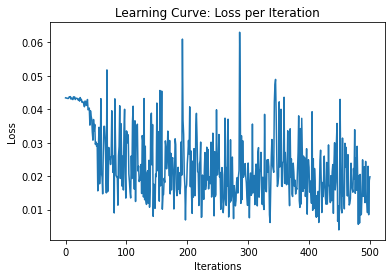

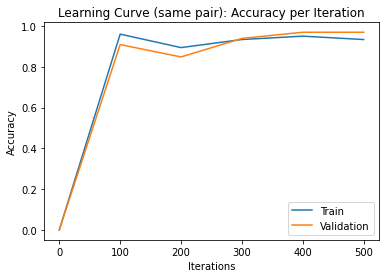

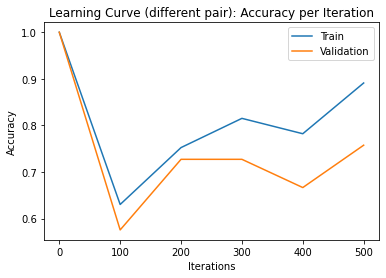

Hyper Parameters: N feature: 4, Batch Size: 32 
Iter 0.  ([Val Acc 50%, Val (Same) Acc 100%, Val (Dif) Acc 0%]  [Train Acc 50% ,Train (Same) Acc 100%, Train (Dif) Acc 0%, Loss 0.693986]
Iter 100.  ([Val Acc 85%, Val (Same) Acc 91%, Val (Dif) Acc 79%]  [Train Acc 85% ,Train (Same) Acc 91%, Train (Dif) Acc 80%, Loss 0.268476]
Iter 200.  ([Val Acc 79%, Val (Same) Acc 82%, Val (Dif) Acc 76%]  [Train Acc 87% ,Train (Same) Acc 91%, Train (Dif) Acc 83%, Loss 0.266947]
Iter 300.  ([Val Acc 83%, Val (Same) Acc 94%, Val (Dif) Acc 73%]  [Train Acc 90% ,Train (Same) Acc 96%, Train (Dif) Acc 84%, Loss 0.283120]
Iter 400.  ([Val Acc 76%, Val (Same) Acc 91%, Val (Dif) Acc 61%]  [Train Acc 94% ,Train (Same) Acc 99%, Train (Dif) Acc 88%, Loss 0.091419]
Iter 500.  ([Val Acc 79%, Val (Same) Acc 91%, Val (Dif) Acc 67%]  [Train Acc 98% ,Train (Same) Acc 100%, Train (Dif) Acc 96%, Loss 0.042373]


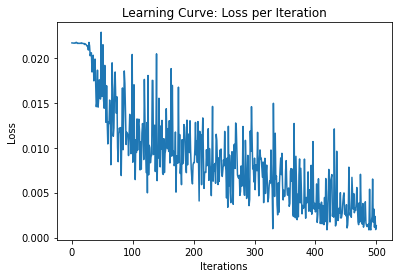

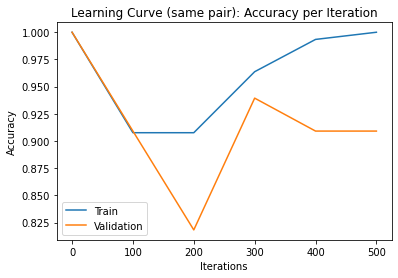

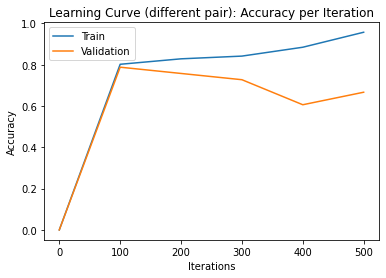

Hyper Parameters: N feature: 4, Batch Size: 64 
Iter 0.  ([Val Acc 50%, Val (Same) Acc 100%, Val (Dif) Acc 0%]  [Train Acc 50% ,Train (Same) Acc 100%, Train (Dif) Acc 0%, Loss 0.693328]
Iter 100.  ([Val Acc 79%, Val (Same) Acc 73%, Val (Dif) Acc 85%]  [Train Acc 88% ,Train (Same) Acc 83%, Train (Dif) Acc 93%, Loss 0.297120]
Iter 200.  ([Val Acc 85%, Val (Same) Acc 88%, Val (Dif) Acc 82%]  [Train Acc 95% ,Train (Same) Acc 93%, Train (Dif) Acc 96%, Loss 0.219725]
Iter 300.  ([Val Acc 80%, Val (Same) Acc 76%, Val (Dif) Acc 85%]  [Train Acc 97% ,Train (Same) Acc 94%, Train (Dif) Acc 99%, Loss 0.112402]
Iter 400.  ([Val Acc 85%, Val (Same) Acc 88%, Val (Dif) Acc 82%]  [Train Acc 99% ,Train (Same) Acc 98%, Train (Dif) Acc 99%, Loss 0.019582]
Iter 500.  ([Val Acc 85%, Val (Same) Acc 88%, Val (Dif) Acc 82%]  [Train Acc 99% ,Train (Same) Acc 98%, Train (Dif) Acc 100%, Loss 0.002939]


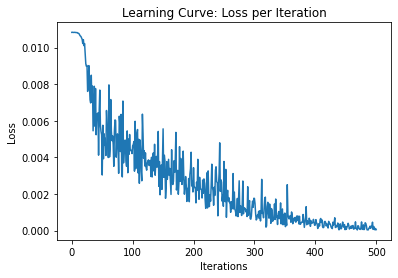

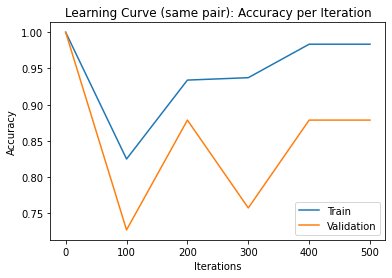

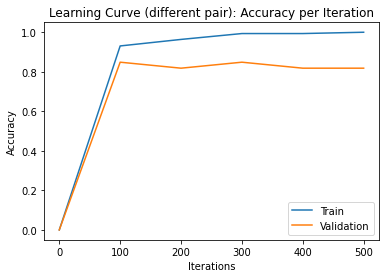

Hyper Parameters: N feature: 8, Batch Size: 16 
Iter 0.  ([Val Acc 50%, Val (Same) Acc 100%, Val (Dif) Acc 0%]  [Train Acc 50% ,Train (Same) Acc 100%, Train (Dif) Acc 0%, Loss 0.694958]
Iter 100.  ([Val Acc 79%, Val (Same) Acc 94%, Val (Dif) Acc 64%]  [Train Acc 83% ,Train (Same) Acc 95%, Train (Dif) Acc 72%, Loss 0.963044]
Iter 200.  ([Val Acc 85%, Val (Same) Acc 85%, Val (Dif) Acc 85%]  [Train Acc 87% ,Train (Same) Acc 81%, Train (Dif) Acc 94%, Loss 0.323534]
Iter 300.  ([Val Acc 83%, Val (Same) Acc 82%, Val (Dif) Acc 85%]  [Train Acc 90% ,Train (Same) Acc 87%, Train (Dif) Acc 93%, Loss 0.475132]
Iter 400.  ([Val Acc 86%, Val (Same) Acc 85%, Val (Dif) Acc 88%]  [Train Acc 93% ,Train (Same) Acc 91%, Train (Dif) Acc 95%, Loss 0.236512]
Iter 500.  ([Val Acc 85%, Val (Same) Acc 85%, Val (Dif) Acc 85%]  [Train Acc 96% ,Train (Same) Acc 96%, Train (Dif) Acc 95%, Loss 0.207613]


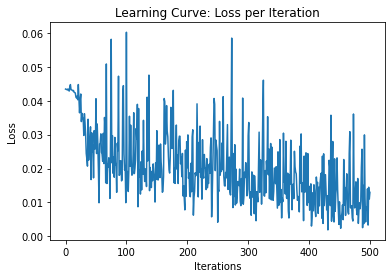

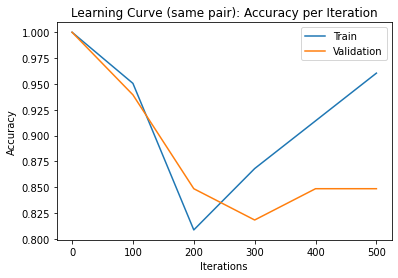

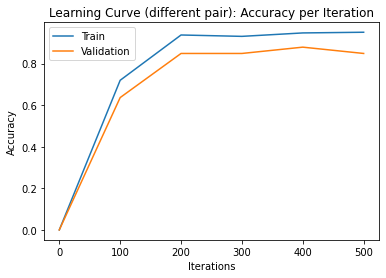

Hyper Parameters: N feature: 8, Batch Size: 32 
Iter 0.  ([Val Acc 50%, Val (Same) Acc 0%, Val (Dif) Acc 100%]  [Train Acc 50% ,Train (Same) Acc 1%, Train (Dif) Acc 100%, Loss 0.694227]
Iter 100.  ([Val Acc 85%, Val (Same) Acc 94%, Val (Dif) Acc 76%]  [Train Acc 86% ,Train (Same) Acc 93%, Train (Dif) Acc 80%, Loss 0.437141]
Iter 200.  ([Val Acc 80%, Val (Same) Acc 97%, Val (Dif) Acc 64%]  [Train Acc 85% ,Train (Same) Acc 96%, Train (Dif) Acc 74%, Loss 0.283071]
Iter 300.  ([Val Acc 83%, Val (Same) Acc 97%, Val (Dif) Acc 70%]  [Train Acc 91% ,Train (Same) Acc 97%, Train (Dif) Acc 84%, Loss 0.173675]
Iter 400.  ([Val Acc 85%, Val (Same) Acc 91%, Val (Dif) Acc 79%]  [Train Acc 94% ,Train (Same) Acc 98%, Train (Dif) Acc 91%, Loss 0.132547]
Iter 500.  ([Val Acc 83%, Val (Same) Acc 88%, Val (Dif) Acc 79%]  [Train Acc 99% ,Train (Same) Acc 98%, Train (Dif) Acc 99%, Loss 0.028111]


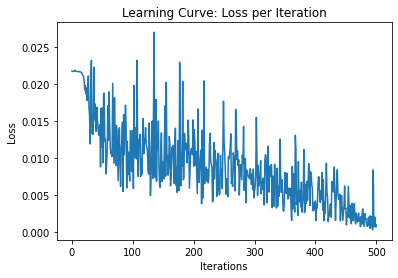

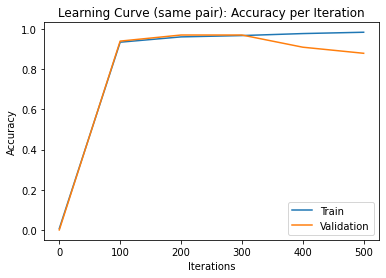

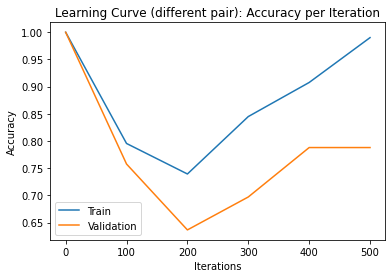

Hyper Parameters: N feature: 8, Batch Size: 64 
Iter 0.  ([Val Acc 50%, Val (Same) Acc 100%, Val (Dif) Acc 0%]  [Train Acc 50% ,Train (Same) Acc 100%, Train (Dif) Acc 0%, Loss 0.693503]
Iter 100.  ([Val Acc 82%, Val (Same) Acc 94%, Val (Dif) Acc 70%]  [Train Acc 86% ,Train (Same) Acc 92%, Train (Dif) Acc 79%, Loss 0.314138]
Iter 200.  ([Val Acc 79%, Val (Same) Acc 85%, Val (Dif) Acc 73%]  [Train Acc 95% ,Train (Same) Acc 93%, Train (Dif) Acc 98%, Loss 0.137737]
Iter 300.  ([Val Acc 82%, Val (Same) Acc 85%, Val (Dif) Acc 79%]  [Train Acc 99% ,Train (Same) Acc 99%, Train (Dif) Acc 99%, Loss 0.040641]
Iter 400.  ([Val Acc 80%, Val (Same) Acc 97%, Val (Dif) Acc 64%]  [Train Acc 94% ,Train (Same) Acc 100%, Train (Dif) Acc 88%, Loss 0.226095]
Iter 500.  ([Val Acc 83%, Val (Same) Acc 88%, Val (Dif) Acc 79%]  [Train Acc 100% ,Train (Same) Acc 100%, Train (Dif) Acc 100%, Loss 0.003150]


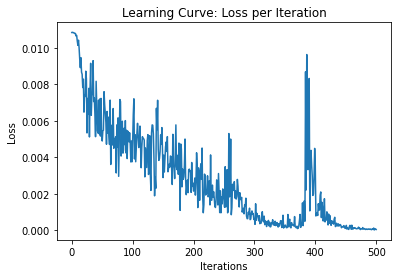

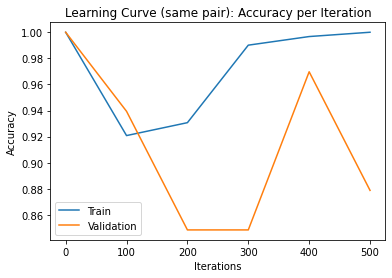

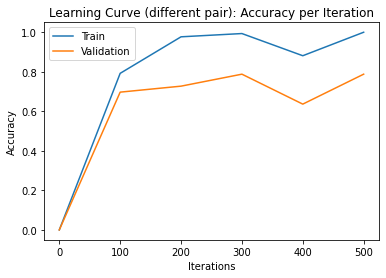

In [ ]:
# Include the training curves for the two models.
kernel_size1 = 5
batch_l = [16,32,64]
n_features1_l = [4,8]

for n in n_features1_l:
  for b_sz in batch_l:
    print("Hyper Parameters: N feature: %d, Batch Size: %d " % (
                n, b_sz))
    pytorch_cnn_channel = CNNChannel(n, kernel_size1)
    iters, losses, iters_sub, train_pos_accs, train_neg_accs, val_pos_accs, val_neg_accs = train_model(pytorch_cnn_channel,
                                                                                                      train_data,
                                                                                                        val_data,
                                                                                                        batch_size=b_sz,
                                                                                                        learning_rate=0.0005,
                                                                                                        weight_decay=0,
                                                                                                        max_iters=500,
                                                                                                        checkpoint_path=None)

      
    plot_learning_curve(iters, losses, iters_sub, train_pos_accs, train_neg_accs, val_pos_accs, val_neg_accs)


Training CNN model

Hyper Parameters: N feature: 8, Batch Size: 16
Iter 0.  ([Val Acc 50%, Val (Same) Acc 100%, Val (Dif) Acc 0%]  [Train Acc 50% ,Train (Same) Acc 100%, Train (Dif) Acc 0%, Loss 0.693723]
Iter 100.  ([Val Acc 50%, Val (Same) Acc 100%, Val (Dif) Acc 0%]  [Train Acc 50% ,Train (Same) Acc 100%, Train (Dif) Acc 0%, Loss 0.693264]
Iter 200.  ([Val Acc 50%, Val (Same) Acc 0%, Val (Dif) Acc 100%]  [Train Acc 50% ,Train (Same) Acc 0%, Train (Dif) Acc 100%, Loss 0.693190]
Iter 300.  ([Val Acc 52%, Val (Same) Acc 100%, Val (Dif) Acc 3%]  [Train Acc 52% ,Train (Same) Acc 92%, Train (Dif) Acc 12%, Loss 0.692985]
Iter 400.  ([Val Acc 53%, Val (Same) Acc 70%, Val (Dif) Acc 36%]  [Train Acc 55% ,Train (Same) Acc 66%, Train (Dif) Acc 44%, Loss 0.694009]


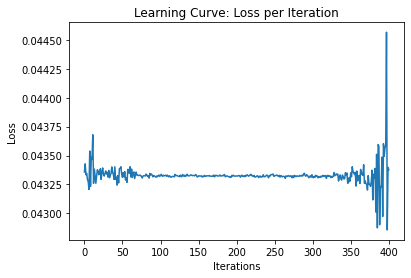

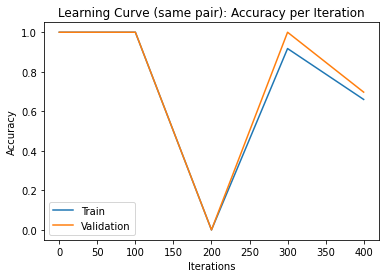

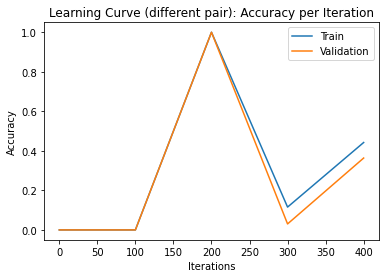

Hyper Parameters: N feature: 8, Batch Size: 32
Iter 0.  ([Val Acc 50%, Val (Same) Acc 100%, Val (Dif) Acc 0%]  [Train Acc 50% ,Train (Same) Acc 100%, Train (Dif) Acc 0%, Loss 0.698391]
Iter 100.  ([Val Acc 48%, Val (Same) Acc 88%, Val (Dif) Acc 9%]  [Train Acc 50% ,Train (Same) Acc 91%, Train (Dif) Acc 9%, Loss 0.693307]
Iter 200.  ([Val Acc 50%, Val (Same) Acc 18%, Val (Dif) Acc 82%]  [Train Acc 51% ,Train (Same) Acc 15%, Train (Dif) Acc 88%, Loss 0.693007]
Iter 300.  ([Val Acc 48%, Val (Same) Acc 76%, Val (Dif) Acc 21%]  [Train Acc 53% ,Train (Same) Acc 77%, Train (Dif) Acc 28%, Loss 0.695058]
Iter 400.  ([Val Acc 48%, Val (Same) Acc 76%, Val (Dif) Acc 21%]  [Train Acc 56% ,Train (Same) Acc 70%, Train (Dif) Acc 42%, Loss 0.661601]


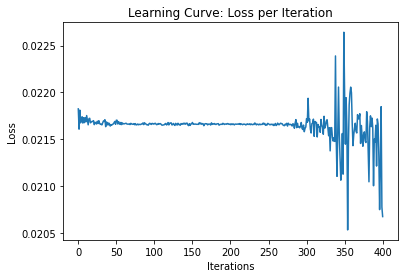

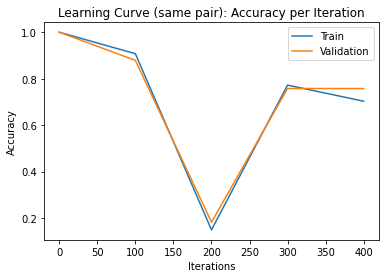

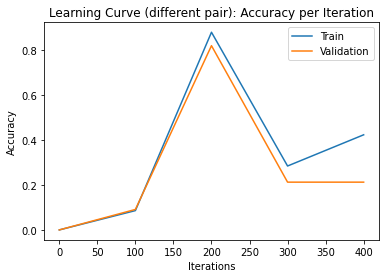

Hyper Parameters: N feature: 8, Batch Size: 64
Iter 0.  ([Val Acc 52%, Val (Same) Acc 3%, Val (Dif) Acc 100%]  [Train Acc 50% ,Train (Same) Acc 5%, Train (Dif) Acc 95%, Loss 0.693119]
Iter 100.  ([Val Acc 48%, Val (Same) Acc 0%, Val (Dif) Acc 97%]  [Train Acc 52% ,Train (Same) Acc 36%, Train (Dif) Acc 69%, Loss 0.693072]
Iter 200.  ([Val Acc 53%, Val (Same) Acc 67%, Val (Dif) Acc 39%]  [Train Acc 57% ,Train (Same) Acc 66%, Train (Dif) Acc 48%, Loss 0.684118]
Iter 300.  ([Val Acc 56%, Val (Same) Acc 79%, Val (Dif) Acc 33%]  [Train Acc 60% ,Train (Same) Acc 69%, Train (Dif) Acc 50%, Loss 0.667626]
Iter 400.  ([Val Acc 55%, Val (Same) Acc 82%, Val (Dif) Acc 27%]  [Train Acc 62% ,Train (Same) Acc 79%, Train (Dif) Acc 46%, Loss 0.644202]


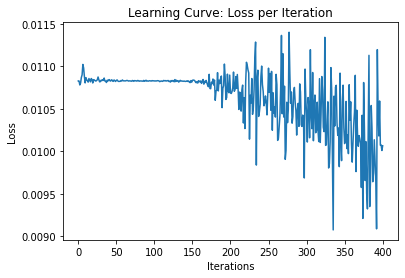

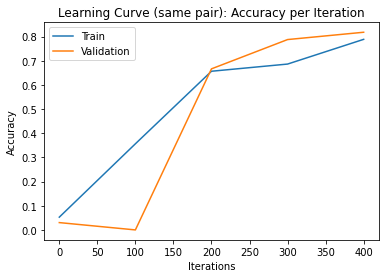

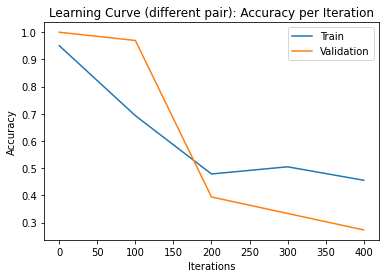

Hyper Parameters: N feature: 16, Batch Size: 16
Iter 0.  ([Val Acc 50%, Val (Same) Acc 100%, Val (Dif) Acc 0%]  [Train Acc 50% ,Train (Same) Acc 100%, Train (Dif) Acc 0%, Loss 0.693246]
Iter 100.  ([Val Acc 52%, Val (Same) Acc 45%, Val (Dif) Acc 58%]  [Train Acc 50% ,Train (Same) Acc 31%, Train (Dif) Acc 69%, Loss 0.693401]
Iter 200.  ([Val Acc 50%, Val (Same) Acc 0%, Val (Dif) Acc 100%]  [Train Acc 50% ,Train (Same) Acc 0%, Train (Dif) Acc 100%, Loss 0.693161]
Iter 300.  ([Val Acc 50%, Val (Same) Acc 0%, Val (Dif) Acc 100%]  [Train Acc 50% ,Train (Same) Acc 0%, Train (Dif) Acc 100%, Loss 0.693162]
Iter 400.  ([Val Acc 50%, Val (Same) Acc 0%, Val (Dif) Acc 100%]  [Train Acc 50% ,Train (Same) Acc 0%, Train (Dif) Acc 100%, Loss 0.693151]


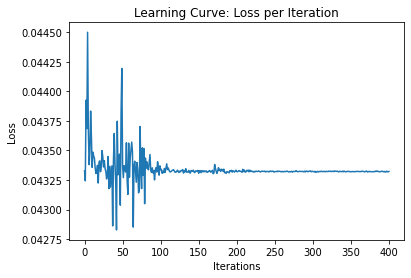

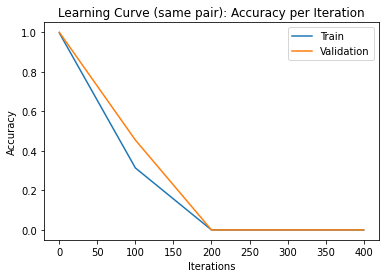

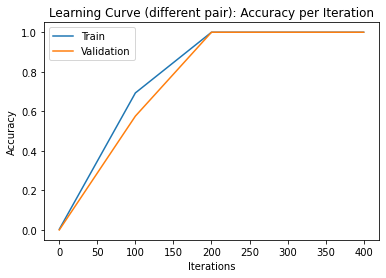

Hyper Parameters: N feature: 16, Batch Size: 32
Iter 0.  ([Val Acc 50%, Val (Same) Acc 0%, Val (Dif) Acc 100%]  [Train Acc 50% ,Train (Same) Acc 0%, Train (Dif) Acc 100%, Loss 0.693089]
Iter 100.  ([Val Acc 50%, Val (Same) Acc 100%, Val (Dif) Acc 0%]  [Train Acc 50% ,Train (Same) Acc 99%, Train (Dif) Acc 1%, Loss 0.693178]
Iter 200.  ([Val Acc 53%, Val (Same) Acc 36%, Val (Dif) Acc 70%]  [Train Acc 53% ,Train (Same) Acc 37%, Train (Dif) Acc 69%, Loss 0.693173]
Iter 300.  ([Val Acc 55%, Val (Same) Acc 73%, Val (Dif) Acc 36%]  [Train Acc 55% ,Train (Same) Acc 75%, Train (Dif) Acc 36%, Loss 0.673354]
Iter 400.  ([Val Acc 53%, Val (Same) Acc 70%, Val (Dif) Acc 36%]  [Train Acc 57% ,Train (Same) Acc 73%, Train (Dif) Acc 42%, Loss 0.645187]


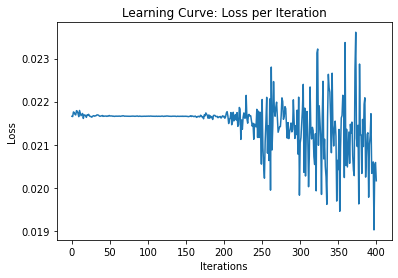

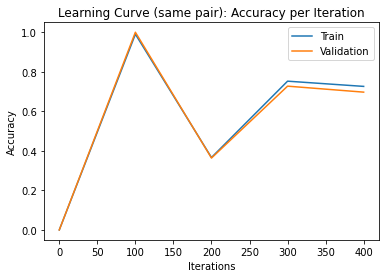

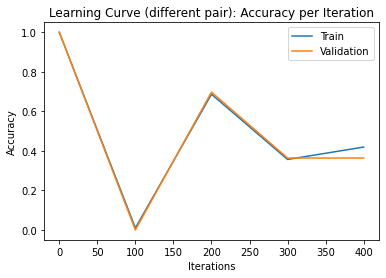

Hyper Parameters: N feature: 16, Batch Size: 64
Iter 0.  ([Val Acc 50%, Val (Same) Acc 0%, Val (Dif) Acc 100%]  [Train Acc 50% ,Train (Same) Acc 0%, Train (Dif) Acc 100%, Loss 0.695179]
Iter 100.  ([Val Acc 52%, Val (Same) Acc 76%, Val (Dif) Acc 27%]  [Train Acc 51% ,Train (Same) Acc 90%, Train (Dif) Acc 12%, Loss 0.693171]
Iter 200.  ([Val Acc 56%, Val (Same) Acc 70%, Val (Dif) Acc 42%]  [Train Acc 56% ,Train (Same) Acc 68%, Train (Dif) Acc 45%, Loss 0.674473]
Iter 300.  ([Val Acc 59%, Val (Same) Acc 91%, Val (Dif) Acc 27%]  [Train Acc 68% ,Train (Same) Acc 92%, Train (Dif) Acc 44%, Loss 0.648791]
Iter 400.  ([Val Acc 80%, Val (Same) Acc 88%, Val (Dif) Acc 73%]  [Train Acc 85% ,Train (Same) Acc 85%, Train (Dif) Acc 84%, Loss 0.339671]


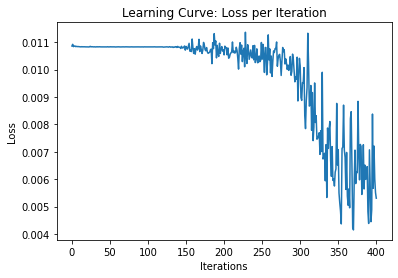

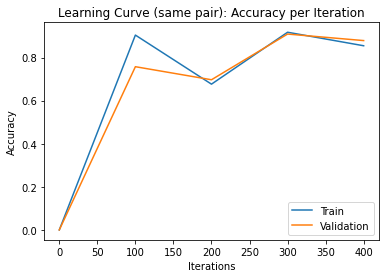

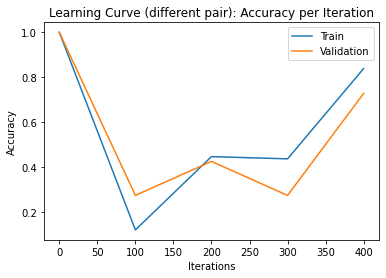

In [ ]:
print("Training CNN model")
print("")

kernel_size2 = 5
batch_l = [16,32,64]
n_features2_l = [8,16]

for n in n_features2_l:
  for b_sz in batch_l:
    pytorch_cnn = CNN(n,kernel_size2)
    print("Hyper Parameters: N feature: %d, Batch Size: %d" % (
                n, b_sz))
    iters, losses, iters_sub, train_pos_accs, train_neg_accs, val_pos_accs, val_neg_accs = train_model(pytorch_cnn,
                                                                                                      train_data,
                                                                                                        val_data,
                                                                                                        batch_size=b_sz,
                                                                                                        learning_rate=0.0004,
                                                                                                        weight_decay=0,
                                                                                                        max_iters=400,
                                                                                                        checkpoint_path=None)

    plot_learning_curve(iters, losses, iters_sub, train_pos_accs, train_neg_accs, val_pos_accs, val_neg_accs)

### Part (d) -- 4%

Include your training curves for the **best** models from each of Q2(a) and Q2(b).
These are the models that you will use in Question 4.

Iter 0.  ([Val Acc 50%, Val (Same) Acc 100%, Val (Dif) Acc 0%]  [Train Acc 50% ,Train (Same) Acc 100%, Train (Dif) Acc 0%, Loss 0.695903]
Iter 100.  ([Val Acc 82%, Val (Same) Acc 94%, Val (Dif) Acc 70%]  [Train Acc 83% ,Train (Same) Acc 95%, Train (Dif) Acc 71%, Loss 0.334715]
Iter 200.  ([Val Acc 83%, Val (Same) Acc 97%, Val (Dif) Acc 70%]  [Train Acc 85% ,Train (Same) Acc 94%, Train (Dif) Acc 77%, Loss 0.590774]
Iter 300.  ([Val Acc 83%, Val (Same) Acc 97%, Val (Dif) Acc 70%]  [Train Acc 88% ,Train (Same) Acc 92%, Train (Dif) Acc 84%, Loss 0.402133]
Iter 400.  ([Val Acc 80%, Val (Same) Acc 88%, Val (Dif) Acc 73%]  [Train Acc 89% ,Train (Same) Acc 90%, Train (Dif) Acc 88%, Loss 0.109485]
Iter 500.  ([Val Acc 79%, Val (Same) Acc 73%, Val (Dif) Acc 85%]  [Train Acc 92% ,Train (Same) Acc 90%, Train (Dif) Acc 94%, Loss 0.101899]
Iter 600.  ([Val Acc 76%, Val (Same) Acc 79%, Val (Dif) Acc 73%]  [Train Acc 94% ,Train (Same) Acc 97%, Train (Dif) Acc 91%, Loss 0.072064]
Iter 700.  ([Val Acc 8

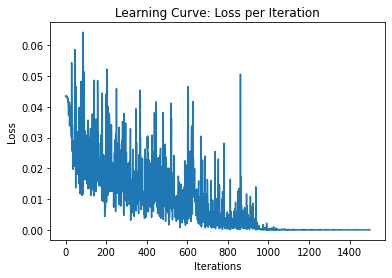

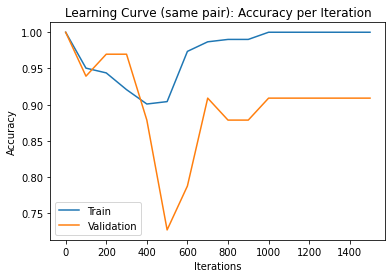

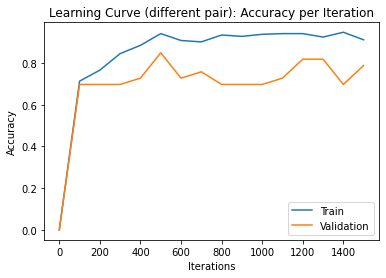

In [ ]:
# Include the training curves for the two models.
#CNNchannel model - chosen hyper parameters: N feature: 8, Batch Size: 16, Learning rate: 0.0005
pytorch_cnn_channel = CNNChannel(8, 5)
iters, losses, iters_sub, train_pos_accs, train_neg_accs, val_pos_accs, val_neg_accs = train_model(pytorch_cnn_channel,
                                                                                                        train_data,
                                                                                                          val_data,
                                                                                                          batch_size=16,
                                                                                                          learning_rate=0.0005,
                                                                                                          weight_decay=0,
                                                                                                          max_iters=1500,
                                                                                                          checkpoint_path='/content/gdrive/My Drive/Intro_to_Deep_Learning/mlp_CNNchannel/ckpt-{}.pk')
plot_learning_curve(iters, losses, iters_sub, train_pos_accs, train_neg_accs, val_pos_accs, val_neg_accs)


Iter 0.  ([Val Acc 52%, Val (Same) Acc 12%, Val (Dif) Acc 91%]  [Train Acc 50% ,Train (Same) Acc 4%, Train (Dif) Acc 96%, Loss 0.693130]
Iter 100.  ([Val Acc 52%, Val (Same) Acc 3%, Val (Dif) Acc 100%]  [Train Acc 50% ,Train (Same) Acc 1%, Train (Dif) Acc 99%, Loss 0.693151]
Iter 200.  ([Val Acc 56%, Val (Same) Acc 82%, Val (Dif) Acc 30%]  [Train Acc 56% ,Train (Same) Acc 82%, Train (Dif) Acc 29%, Loss 0.688977]
Iter 300.  ([Val Acc 52%, Val (Same) Acc 73%, Val (Dif) Acc 30%]  [Train Acc 57% ,Train (Same) Acc 78%, Train (Dif) Acc 36%, Loss 0.646782]
Iter 400.  ([Val Acc 59%, Val (Same) Acc 73%, Val (Dif) Acc 45%]  [Train Acc 59% ,Train (Same) Acc 73%, Train (Dif) Acc 44%, Loss 0.670721]
Iter 500.  ([Val Acc 58%, Val (Same) Acc 70%, Val (Dif) Acc 45%]  [Train Acc 61% ,Train (Same) Acc 71%, Train (Dif) Acc 52%, Loss 0.627710]
Iter 600.  ([Val Acc 53%, Val (Same) Acc 73%, Val (Dif) Acc 33%]  [Train Acc 62% ,Train (Same) Acc 77%, Train (Dif) Acc 48%, Loss 0.710763]
Iter 700.  ([Val Acc 53%

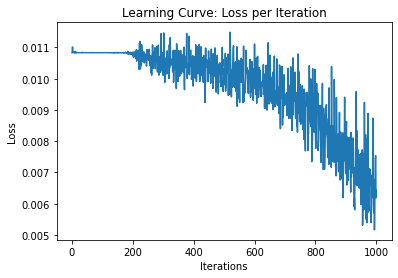

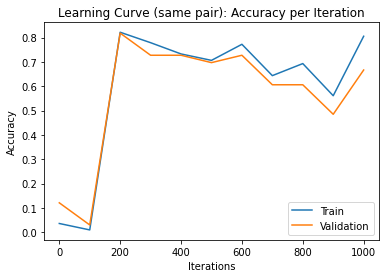

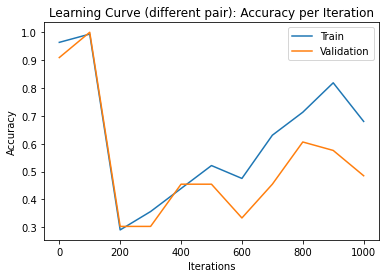

In [ ]:
#CNN model - chosen hyper parameters: N feature: 16, Batch Size: 64, Learning rate: 0.0004
pytorch_cnn_channel = CNN(16,5)
iters, losses, iters_sub, train_pos_accs, train_neg_accs, val_pos_accs, val_neg_accs = train_model(pytorch_cnn_channel,
                                                                                                  train_data,
                                                                                                    val_data,
                                                                                                    batch_size=64,
                                                                                                    learning_rate=0.0004,
                                                                                                    weight_decay=0,
                                                                                                    max_iters=1000,
                                                                                                    checkpoint_path='/content/gdrive/My Drive/Intro_to_Deep_Learning/mlp_CNN/ckpt-{}.pk')


plot_learning_curve(iters, losses, iters_sub, train_pos_accs, train_neg_accs, val_pos_accs, val_neg_accs)

## Question 4. Testing (15%)

### Part (a) -- 7%

Report the test accuracies of your **single best** model,
separately for the two test sets.
Do this by choosing the  model
architecture that produces the best validation accuracy. For instance,
if your model attained the
best validation accuracy in epoch 12, then the weights at epoch 12 is what you should be using
to report the test accuracy.

In [ ]:
# Write your code here. Make sure to include the test accuracy in your report 
model = CNNChannel(8, 5) 
model.load_state_dict(torch.load('/content/gdrive/My Drive/Intro_to_Deep_Learning/mlp_CNNchannel/ckpt-1300.pk'))

pos_acc_m, neg_acc_m= get_accuracy(model, test_m, 30)
false_positive_m = 1 - pos_acc_m
false_negative_m = 1 - neg_acc_m
print("Test Accuracy-Male : Same Pairs Acc = %.0f%%, Fasle Positive = %.0f%%, Diff Pair Acc = %.0f%%, False Negetive = %.0f%%" % (pos_acc_m*100, false_positive_m*100,
                                                                                                                            neg_acc_m*100,false_negative_m*100))
pos_acc_m, neg_acc_m= get_accuracy(model, test_w, 30)
false_positive_m = 1 - pos_acc_m
false_negative_m = 1 - neg_acc_m
print("Test Accuracy-Female : Same Pairs Acc = %.0f%%, Fasle Positive = %.0f%%, Diff Pair Acc = %.0f%%, False Negetive = %.0f%%" % (pos_acc_m*100, false_positive_m*100,
                                                                                                                            neg_acc_m*100,false_negative_m*100))

Test Accuracy-Male : Same Pairs Acc = 83%, Fasle Positive = 17%, Diff Pair Acc = 80%, False Negetive = 20%
Test Accuracy-Female : Same Pairs Acc = 93%, Fasle Positive = 7%, Diff Pair Acc = 83%, False Negetive = 17%


### Part (b) -- 4%

Display one set of men's shoes that your model correctly classified as being
from the same pair.

If your test accuracy was not 100% on the men's shoes test set,
display one set of inputs that your model classified incorrectly.

In [ ]:
def model_pred(pred):
  if pred == 0:
    print("The model predicted they are from the Same Pair")
  else:
    print("The model predicted they are from Different Pairs")
  return


def test_model_same(model=CNNChannel(4, 5),file=0, test_data=test_m, user=0,pair=0):
  if file == 0:
    model.load_state_dict(torch.load('/content/gdrive/My Drive/Intro_to_Deep_Learning/mlp_CNNchannel/ckpt-1300.pk'))
  else:
    model.load_state_dict(torch.load('/content/gdrive/My Drive/Intro_to_Deep_Learning/mlp_CNN/ckpt-400.pk'))
  test_same = generate_same_pair(test_data[user:user+1]) #should be [3, 448, 224, 3]
  plt.figure()
  plt.imshow(test_same[pair]+0.5)

  test_same = torch.Tensor(test_same[pair:pair+1]).transpose(1, 3) #x should be of size: [1, 3, 224, 448]

  zs = model(test_same)
  pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
  pred = pred.detach().numpy()

  return model_pred(pred)


def test_model_diff(model=CNNChannel(4, 5),file=0, test_data=test_m, user=0,pair=0):
  if file == 0:
      model.load_state_dict(torch.load('/content/gdrive/My Drive/Intro_to_Deep_Learning/mlp_CNNchannel/ckpt-1300.pk'))
  else:
    model.load_state_dict(torch.load('/content/gdrive/My Drive/Intro_to_Deep_Learning/mlp_CNN/ckpt-400.pk'))
  test_same = generate_different_pair(test_data[user:user+1]) #should be [3, 448, 224, 3]
  plt.figure()
  plt.imshow(test_same[pair]+0.5)

  test_same = torch.Tensor(test_same[pair:pair+1]).transpose(1, 3) #x should be of size: [1, 3, 224, 448]

  zs = model(test_same)
  pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
  pred = pred.detach().numpy()

  return model_pred(pred)

The model predicted they are from the Same Pair


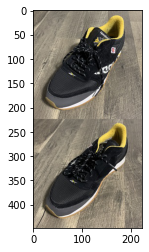

In [ ]:
#Correct prediction:
model = CNNChannel(8, 5)
test_model_same(model,0,test_m, 0)

The model predicted they are from Different Pairs


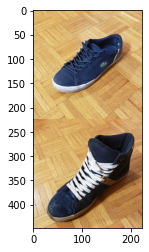

In [ ]:
#Correct prediction:
test_model_diff(model,0,test_m, 5)

The model predicted they are from Different Pairs


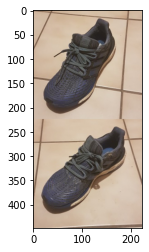

In [ ]:
#Incorrect prediction:
model = CNNChannel(8, 5)
test_model_same(model,0,test_m, 9)



### Part (c) -- 4%

Display one set of women's shoes that your model correctly classified as being
from the same pair.

If your test accuracy was not 100% on the women's shoes test set,
display one set of inputs that your model classified incorrectly.

The model predicted they are from the Same Pair


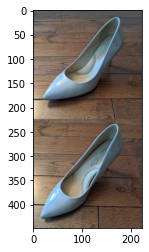

In [ ]:
#Correct prediction:
model = CNNChannel(8, 5)  
test_model_same(model,0, test_w, 0)

The model predicted they are from Different Pairs


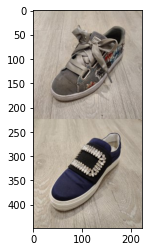

In [ ]:
#Correct prediction:
model = CNNChannel(8, 5) 
test_model_diff(model,0,test_w, 5)

The model predicted they are from the Same Pair


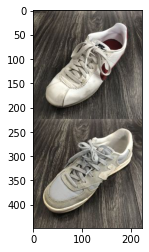

In [ ]:
#Incorrect prediction:
test_model_diff(model,0,test_w, 1)